In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [2]:
total = pd.read_csv('./total_data_plos_only_cleaned.csv')
total.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,doi,year,month,day,volume,issue,journal,title,text,abstract,keywords,retraction_binary,unpacked_keywords,clean_text,clean_text_lem
0,0,0,0,10.1208/s12249-016-0596-x,2016.0,8.0,10.0,18.0,5.0,AAPS PharmSciTech,Study of the Transformations of Micro/Nano-cry...,‘Polymorphism’ generally referred as the abili...,This study elucidates the physical properties ...,"['monoclinic', 'nano-sized crystals', 'orthorh...",1,"['monoclinic', 'nano-sized', 'crystals', 'orth...",Polymorphism generally referred as the ability...,Polymorphism generally referred a the ability ...
1,1,1,1,10.1021/acscentsci.9b00224,2019.0,5.0,9.0,5.0,6.0,ACS central science,Targeted Protein Internalization and Degradati...,Traditional\ndrug development efforts are focu...,Targeted,[],1,[],Traditional drug development efforts are focus...,Traditional drug development effort are focuse...
2,2,2,2,10.1021/acsomega.8b00488,2018.0,6.0,27.0,3.0,6.0,ACS omega,Regulating the Microstructure of Intumescent F...,Intumescent flame retardants\nare now being us...,A compatibilizer,[],1,[],Intumescent flame retardants are now being use...,Intumescent flame retardant are now being used...
3,3,3,3,10.1021/acsomega.8b00153,2018.0,6.0,25.0,3.0,6.0,ACS omega,Solid-to-Solid Crystallization of Organic Thin...,Crystal growth process is basic and essential ...,The solid-to-solid crystallization processes o...,[],1,[],Crystal growth process is basic and essential ...,Crystal growth process is basic and essential ...
4,4,4,4,10.1107/S1600536811022574,2011.0,6.0,18.0,67.0,NaN,"Acta crystallographica. Section E, Structure r...",Oxonium picrate.,For general background to organic salts of pic...,"The title compound, H3O+·C6H2N3O7",[],1,[],For general background to organic salts of pic...,For general background to organic salt of picr...


In [3]:
total = total.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [4]:
total.columns

Index(['doi', 'year', 'month', 'day', 'volume', 'issue', 'journal', 'title',
       'text', 'abstract', 'keywords', 'retraction_binary',
       'unpacked_keywords', 'clean_text', 'clean_text_lem'],
      dtype='object')

In [4]:
no_retract = pd.read_csv('./no_retraction_data_plos_only_cleaned.csv')
no_retract = no_retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [5]:
retract = pd.read_csv('./retraction_data_plos_only_cleaned.csv')
retract = retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [74]:
total['year'] = total['year'].astype(str)
total['month'] = total['month'].astype(str)
total['day'] = total['day'].astype(str)
total['volume'] = total['volume'].astype(str)
total['issue'] = total['issue'].astype(str)

retract['year'] = retract['year'].astype(float)
retract['month'] = retract['month'].astype(float)
retract['day'] = retract['day'].astype(float)
retract['volume'] = retract['volume'].astype(float)
retract['issue'] = retract['issue'].astype(float)

no_retract['year'] = no_retract['year'].astype(float)
no_retract['month'] = no_retract['month'].astype(float)
no_retract['day'] = no_retract['day'].astype(float)
no_retract['volume'] = no_retract['volume'].astype(float)
no_retract['issue'] = no_retract['issue'].astype(float)

In [8]:
total.loc[total['abstract'].isnull()==True].index

Int64Index([   45,   183,   186,   217,   286,   346,   462,   698,   744,
              783,
            ...
             9847,  9925,  9946, 10146, 10148, 10270, 10425, 10479, 10481,
            10496],
           dtype='int64', length=115)

In [9]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10743 entries, 0 to 10742
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   doi                10743 non-null  object
 1   year               10743 non-null  object
 2   month              10743 non-null  object
 3   day                10743 non-null  object
 4   volume             10743 non-null  object
 5   issue              10743 non-null  object
 6   journal            10743 non-null  object
 7   title              10743 non-null  object
 8   text               10743 non-null  object
 9   abstract           10628 non-null  object
 10  keywords           10743 non-null  object
 11  retraction_binary  10743 non-null  int64 
 12  unpacked_keywords  1537 non-null   object
 13  clean_text         10743 non-null  object
 14  clean_text_lem     10743 non-null  object
dtypes: int64(1), object(14)
memory usage: 1.2+ MB


## Feature Engineering

### Keywords

#### Retraction

In [10]:
#https://stackoverflow.com/questions/40950791/remove-quotes-from-string-in-python
keywords_list = []
count = 0
for i in retract['keywords']:
    if i == []:
        pass
    else:
        for j in i.split():
            keywords_list.append(j.replace("'",'').replace('[','').replace(',','').replace(']','').replace('(','').replace(')','').replace('\\n', '').replace('\\n','').lower())

In [11]:
#cells -> cell
lemmatizer = WordNetLemmatizer()
ls_keywords = []
for i in keywords_list:
    ls_keywords.append(lemmatizer.lemmatize(i))
pd.Series(ls_keywords).value_counts().head(11)

            663
cell        186
antibody    116
cancer      112
response     89
disease      84
health       79
factor       71
theory       67
gene         66
hiv          61
dtype: int64

#### No Retraction

In [12]:
no_retract['keywords'].value_counts()

[]                                                                            9205
['Socioeconomic inequality', 'Antenatal care', 'Decomposition', 'Nigeria']       1
Name: keywords, dtype: int64

### Word Count

In [13]:
list_words = []
for i in range(0, len(total['clean_text'])):
    list_words.append(len(total['clean_text'][i].split()))
total['num_words'] = list_words 

### Character Length

In [14]:
list_words = []
for i in range(0, len(total['clean_text'])):
    list_words.append(len(total['clean_text'][i]))
total['character_length'] = list_words 

### Animal Studies

In [15]:
total.shape

(10743, 17)

In [16]:
animal_terms = ['IACUC', 'mouse', 'mice', 'rats', 'rat', 'hamster', 'hamsters', 'pigs', 'rabbits', 'rabbit', 
                'cat', 'cats', 'dog', 'dogs', 'ungulate', 'ungulates', 'pig', 'horse', 'donkey', 'goat',
               'bovine', 'porcine', 'murine','chicken']

#http://vetmed.tamu.edu/media/2005639/vadnais%20protein%20therapeutics%202017.pdf
#https://www.ncbi.nlm.nih.gov/books/NBK218261/

In [17]:
list_articles = []
iacuc = []
for i in range(0, len(total['clean_text'])):
    count = 0
    for j in total['clean_text'][i].split():
        for k in animal_terms:
            if j == k:
                if i not in list_articles:
                    list_articles.append(i)
                    iacuc.append(1)
                    count = 1
            else:
                pass
    if count == 0:
        iacuc.append(0)
    else:
        pass
        
print(list_articles)            
print(len(list_articles))
print(len(iacuc))

[21, 22, 25, 26, 27, 30, 31, 32, 33, 34, 38, 41, 47, 48, 51, 54, 58, 60, 63, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 90, 92, 93, 98, 99, 100, 101, 102, 107, 109, 113, 119, 120, 121, 123, 124, 125, 126, 127, 129, 130, 133, 137, 145, 146, 147, 149, 150, 151, 157, 159, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 176, 178, 179, 181, 182, 195, 196, 197, 198, 199, 201, 205, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 223, 225, 226, 227, 229, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 248, 254, 262, 269, 273, 275, 276, 278, 281, 285, 287, 288, 289, 290, 291, 293, 294, 295, 296, 297, 298, 299, 308, 309, 310, 311, 312, 313, 314, 315, 319, 322, 323, 324, 327, 330, 332, 334, 336, 337, 338, 340, 341, 342, 343, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 364, 365, 366, 368, 370, 371, 372, 373, 374, 377, 378, 379, 380, 382, 383, 384, 386, 387, 389, 390, 391, 394, 395, 396, 397, 398, 399, 405, 406, 407, 409, 413, 416, 417, 418,

In [18]:
total['animal_binary'] = iacuc

In [19]:
#need to fix

list_articles = []
list_words = []
for i in range(0, len(total['clean_text'])):
    count = 0
    iacuc = []
    for j in total['clean_text'][i].split():
        for k in animal_terms:
            if j == k:
                if i not in list_articles:
                    if j not in iacuc:
                        list_articles.append(i)
                        iacuc.append(k)
                        count = 1
            else:
                pass
    if count == 0:
        list_words.append([])
    else:
        list_words.append(iacuc)
                    
print(len(list_articles))
print(len(iacuc))
print(list_words[0:5])

4248
1
[[], [], [], [], []]


In [20]:
print(len(list_words))
print(list_words[20:25])

10743
[[], ['rabbit'], ['bovine'], [], []]


In [21]:
total['animal_words'] = list_words

In [22]:
total['animal_words'][:1537].value_counts(normalize=True)

[]           0.493819
[mice]       0.147690
[mouse]      0.085231
[bovine]     0.082628
[rats]       0.048796
[rat]        0.037736
[rabbit]     0.025374
[murine]     0.023422
[dogs]       0.013012
[goat]       0.009109
[chicken]    0.006506
[rabbits]    0.005205
[pigs]       0.004554
[horse]      0.003904
[dog]        0.002602
[pig]        0.002602
[cat]        0.002602
[cats]       0.001952
[porcine]    0.001952
[hamster]    0.000651
[IACUC]      0.000651
Name: animal_words, dtype: float64

In [23]:
total['animal_words'][1537:].value_counts(normalize=True)

[]             0.623072
[mice]         0.082229
[mouse]        0.069954
[bovine]       0.048229
[rats]         0.026722
[rat]          0.023246
[murine]       0.017054
[rabbit]       0.013578
[chicken]      0.012600
[dogs]         0.010319
[cat]          0.009124
[goat]         0.008799
[pigs]         0.008581
[horse]        0.007061
[porcine]      0.006626
[IACUC]        0.006300
[pig]          0.005866
[dog]          0.005540
[rabbits]      0.004562
[cats]         0.003910
[ungulates]    0.002390
[hamster]      0.001629
[ungulate]     0.001195
[hamsters]     0.000760
[donkey]       0.000652
Name: animal_words, dtype: float64

### Human Studies

In [24]:
total.shape

(10743, 19)

In [25]:
list_articles = []
irb = []
for i in range(0, len(total['clean_text'])):
    count = 0
    word_count = 0
    for j in total['clean_text'][i].split():
        if j == 'IRB' or j == 'case':
            if j =='IRB':
                if i not in list_articles:
                    list_articles.append(i)
                    irb.append(1)
                    count = 1
            else:
                try:
                    if total['clean_text'][i].split()[word_count+1] == 'study':
                        if i not in list_articles:
                            list_articles.append(i)
                            irb.append(1)
                            count = 1
                            print(f"{j} {total['clean_text'][i].split()[word_count+1]}")
                    else:
                        pass
                except:
                    pass            
        else:
            pass
        word_count += 1
    if count == 0:
        irb.append(0)
    else:
        pass
        
print(list_articles)            
print(len(list_articles))
print(len(irb))

case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study
case study

In [26]:
total['irb_binary'] = irb
total['irb_binary'][:1537].value_counts(normalize=True)

0    0.956409
1    0.043591
Name: irb_binary, dtype: float64

In [27]:
total['irb_binary'][1537:].value_counts(normalize=True)

0    0.92809
1    0.07191
Name: irb_binary, dtype: float64

### Regulatory Binary

In [28]:
regulatory = []
for i in range(0, len(total['irb_binary'])):
    if total['irb_binary'][i] == 1 or total['animal_binary'][i] == 1:
        if total['irb_binary'][i] == 1 and total['animal_binary'][i] == 1:
            regulatory.append(2)
        else:
            regulatory.append(1)
    else:
        regulatory.append(0)
len(regulatory)

10743

In [29]:
total['reg_binary'] = regulatory
total = total.rename(columns={'reg_binary':'regulatory'})
total['regulatory'][:1537].value_counts(normalize=True)

1    0.488614
0    0.480807
2    0.030579
Name: regulatory, dtype: float64

In [30]:
total['regulatory'][1537:].value_counts(normalize=True)

0    0.568977
1    0.413209
2    0.017814
Name: regulatory, dtype: float64

### Review Binary

In [31]:
list_articles = []
review = []
for i in range(0, len(total['clean_text'])):
    count = 0
    word_count = 0
    for j in total['clean_text'][i].split():
        if j == 'review':
            if total['clean_text'][i].split()[word_count-1] == 'this':
                if i not in list_articles:
                    list_articles.append(i)
                    review.append(1)
                    count = 1
                    print(f"{total['clean_text'][i].split()[word_count-1]} {j}") 
        else:
            pass
        word_count += 1
    if count == 0:
        review.append(0)
    else:
        pass
        
print(list_articles)            
print(len(list_articles))
print(len(review))

this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this review
this

In [32]:
total['review_binary'] = review
total['review_binary'][:1537].value_counts(normalize=True)

0    0.960963
1    0.039037
Name: review_binary, dtype: float64

In [33]:
total['review_binary'][1537:].value_counts(normalize=True)

0    0.980882
1    0.019118
Name: review_binary, dtype: float64

## EDA

### Character Length

In [34]:
list_words = []
for i in range(0, len(retract['clean_text'])):
    list_words.append(len(retract['clean_text'][i]))
retract['character_length'] = list_words 

list_words = []
for i in range(0, len(no_retract['clean_text'])):
    list_words.append(len(no_retract['clean_text'][i]))
no_retract['character_length'] = list_words 

In [35]:
retract['character_length'].describe()

count    1.537000e+03
mean     6.305490e+04
std      1.593842e+05
min      3.500000e+01
25%      1.940000e+04
50%      3.272200e+04
75%      5.515200e+04
max      1.425053e+06
Name: character_length, dtype: float64

In [36]:
no_retract['character_length'].describe()

count      9206.000000
mean      49943.829785
std       26235.178665
min          39.000000
25%       32947.000000
50%       44828.000000
75%       60804.750000
max      614970.000000
Name: character_length, dtype: float64

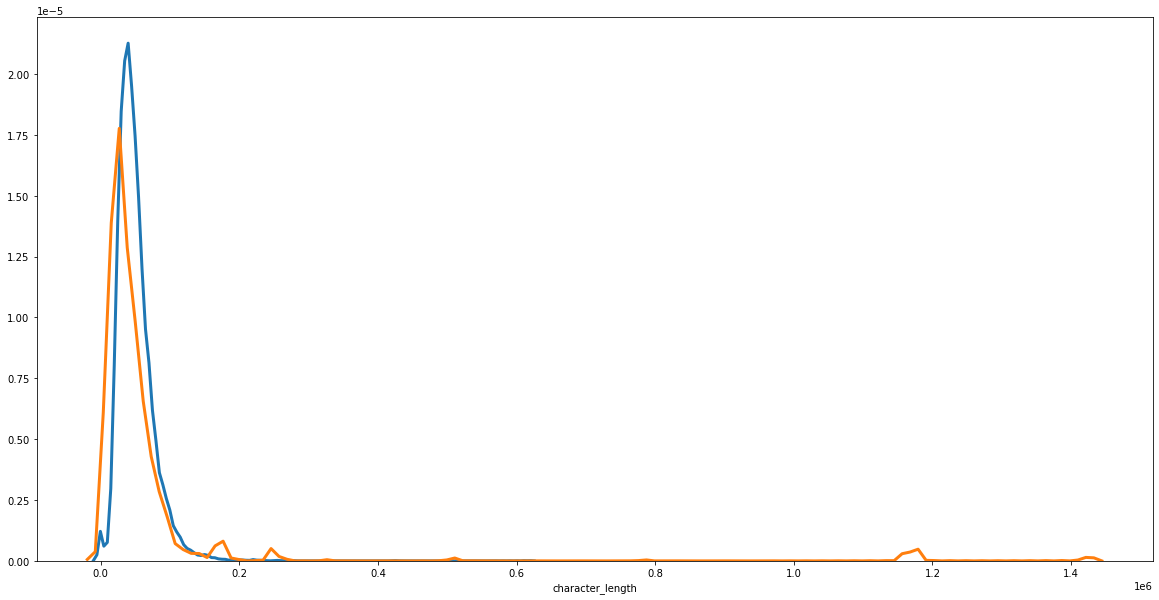

In [37]:
plt.figure(figsize=(20,10))
sns.distplot(no_retract['character_length'], hist=False, kde_kws={"linewidth":3});
sns.distplot(retract['character_length'], hist=False, kde_kws={"linewidth":3});

### Word Count

In [38]:
list_words = []
for i in range(0, len(retract['clean_text'])):
    list_words.append(len(retract['clean_text'][i].split()))
retract['num_words'] = list_words

list_words = []
for i in range(0, len(no_retract['clean_text'])):
    list_words.append(len(no_retract['clean_text'][i].split()))
no_retract['num_words'] = list_words 

In [39]:
retract['num_words'].describe()

count      1537.000000
mean      10076.668185
std       25532.727862
min           6.000000
25%        3042.000000
50%        5152.000000
75%        8917.000000
max      230174.000000
Name: num_words, dtype: float64

In [40]:
no_retract['num_words'].describe()

count     9206.000000
mean      8032.019118
std       4264.290741
min          7.000000
25%       5245.250000
50%       7205.500000
75%       9827.750000
max      95881.000000
Name: num_words, dtype: float64

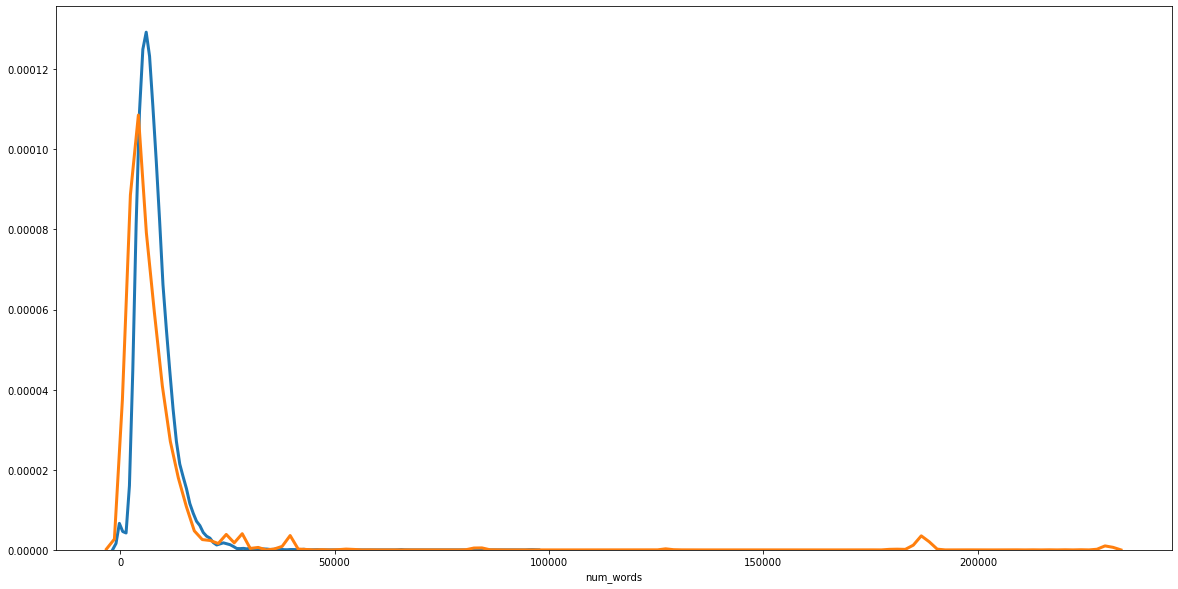

In [41]:
plt.figure(figsize=(20,10))
sns.distplot(no_retract['num_words'], hist=False, kde_kws={"linewidth":3});
sns.distplot(retract['num_words'], hist=False, kde_kws={"linewidth":3});

### Correlation Coefficient Heatmap

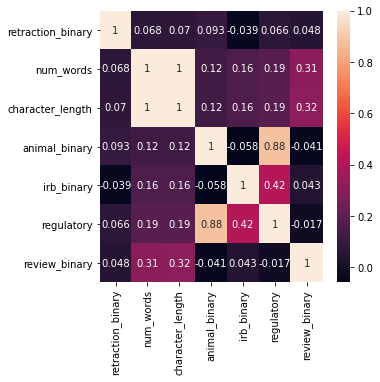

In [42]:
plt.figure(figsize=(5,5))
sns.heatmap(total.corr(), annot=True);

### Keywords Barplots

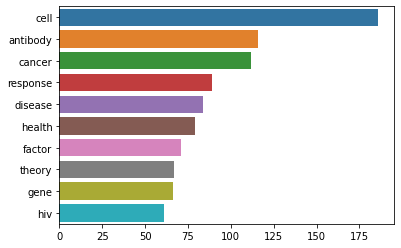

In [43]:
sns.barplot(y=['cell', 'antibody', 'cancer', 'response', 'disease', 'health', 'factor', 'theory', 'gene', 'hiv'],
           x = [186, 116, 112, 89, 84, 79, 71, 67, 66, 61], orient='h');

### Year Barplots

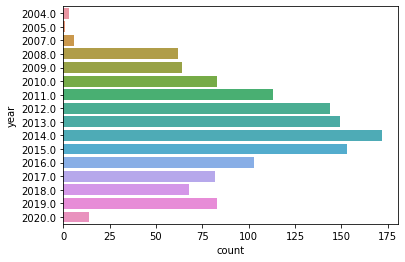

In [75]:
sns.countplot(y= retract['year'], orient='h');

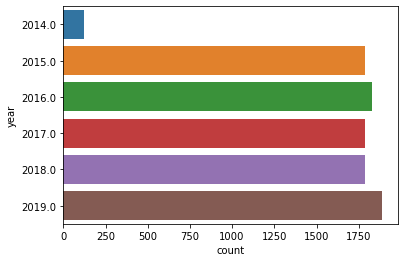

In [76]:
sns.countplot(y =no_retract['year'], orient='h');
#Because of URL set up

### Month Barplots

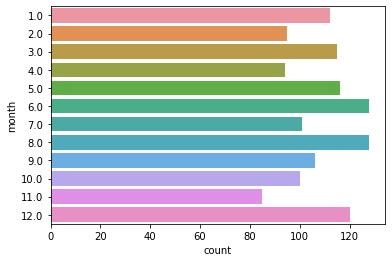

In [77]:
sns.countplot(y=retract['month'], orient='h');

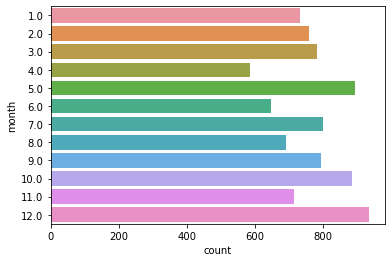

In [78]:
sns.countplot(y=no_retract['month'], orient='h');
#Because of URL set up

### Day Barplots

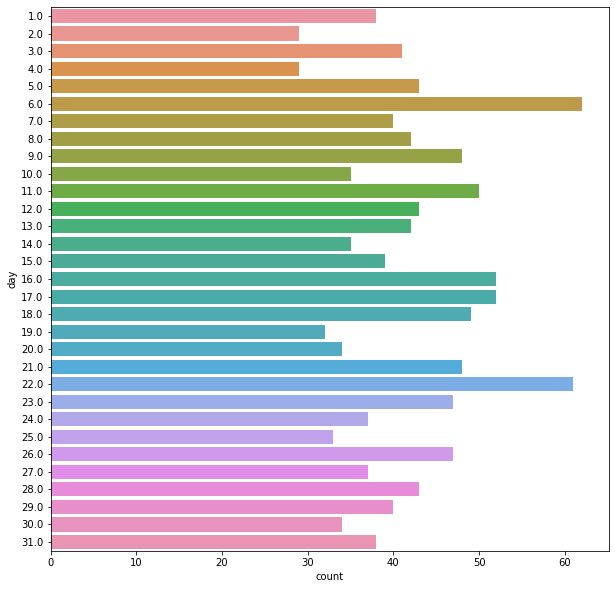

In [79]:
plt.figure(figsize=(10,10))
sns.countplot(y=retract['day'], orient='h');

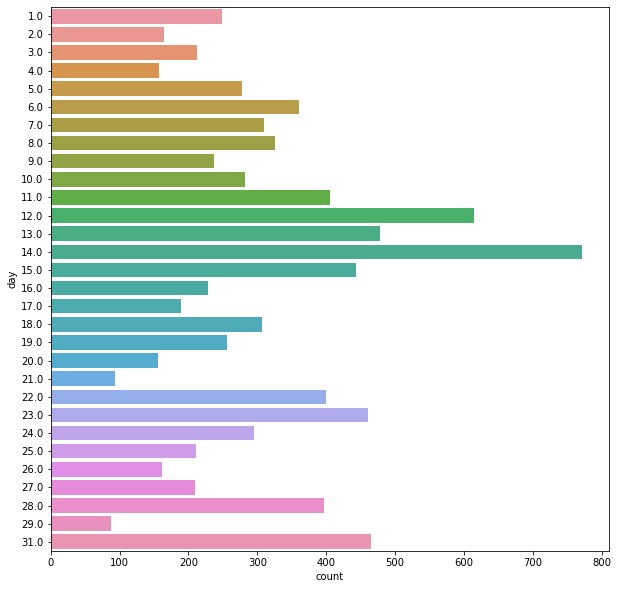

In [80]:
plt.figure(figsize=(10,10))
sns.countplot(y=no_retract['day'], orient='h');

### Volume Barplots

In [57]:
retract['volume'].value_counts().head(11)

9.0     105
7.0     103
8.0      89
10.0     77
5.0      58
11.0     56
12.0     51
6.0      50
3.0      43
nan      34
4.0      33
Name: volume, dtype: int64

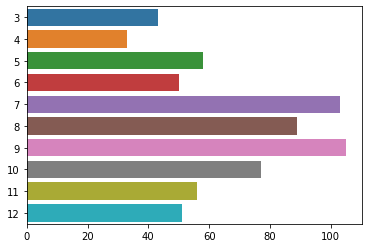

In [6]:
sns.barplot(y=[9, 7, 8, 10, 5, 11, 12, 6, 3, 4],
           x = [105, 103, 89, 77, 58, 56, 51, 50, 43, 33], orient='h');

In [59]:
no_retract['volume'].value_counts().head(11)
#because of URL set up

14.0    1889
11.0    1830
10.0    1790
13.0    1787
12.0    1786
9.0      124
Name: volume, dtype: int64

### Issue Barplots

In [71]:
retract['issue'].value_counts().head(13)

nan     507
1.0     173
3.0      89
4.0      86
2.0      84
6.0      79
5.0      77
7.0      47
8.0      45
10.0     41
12.0     40
11.0     31
9.0      30
Name: issue, dtype: int64

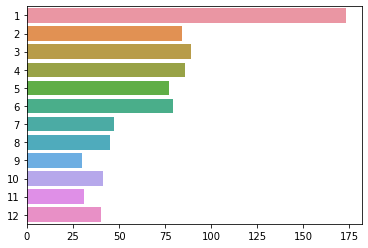

In [82]:
sns.barplot(y=[1, 3, 4, 2, 6, 5, 7, 8, 10, 12, 11, 9],
           x = [173, 89, 86, 84, 79, 77, 47, 45, 41, 40, 31, 30], orient='h');

In [68]:
no_retract['issue'].value_counts().head(12)

12.0    935
5.0     892
10.0    883
7.0     798
9.0     794
3.0     782
2.0     758
1.0     730
11.0    713
8.0     690
6.0     645
4.0     586
Name: issue, dtype: int64

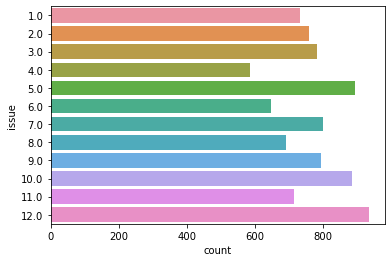

In [83]:
sns.countplot(y=no_retract['issue'], orient='h');